##### Copyright 2020 The TensorFlow Authors.

In [171]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 간단한 오디오 인식: 키워드 인식

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 WAV 형식의 오디오 파일을 사전 처리하고 10개의 다른 단어를 인식하기 위한 기본적인 <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">자동 음성 인식</a>(ASR) 모델을 구축하고 훈련하는 방법을 보여줍니다. "down", "go", "left", "no", "right", "stop", "up" 및 "yes"와 같은 명령의 짧은(1초 이하) 오디오 클립이 포함된 [음성 명령 데이터세트](https://www.tensorflow.org/datasets/catalog/speech_commands)(<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>)의 일부를 사용할 것입니다.

실제 음성 및 오디오 인식 <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">시스템</a>은 복잡합니다. 그러나 [MNIST 데이터세트를 사용한 이미지 분류](../quickstart/beginner.ipynb)와 마찬가지로 이 튜토리얼은 관련된 기술에 대한 기본적인 이해를 제공합니다.

## 설정

필요한 모듈과 종속성을 가져옵니다. 이 튜토리얼에서는 시각화를 위해 <a href="https://seaborn.pydata.org/" class="external">seaborn</a>을 사용할 것입니다.

In [172]:
# Upgrade environment to support TF 2.10 in Colab
#!pip install -U --pre tensorflow tensorflow_datasets
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [173]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## 미니 음성 명령 데이터세트 가져오기

데이터 로드 시간을 절약하기 위해 더 작은 버전의 음성 명령 데이터세트로 작업할 것입니다. [원본 데이터세트](https://www.tensorflow.org/datasets/catalog/speech_commands)는 35개의 다른 단어를 말하는 사람들의 음성이 <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV(Waveform) 오디오 파일 형식</a>으로 담겨 있는 105,000개 이상의 오디오 파일로 구성됩니다. 이 데이터는 Google에서 수집했으며 CC BY의 허가를 얻어 배포했습니다.

`tf.keras.utils.get_file`을 사용하여 작은 음성 명령 데이터세트가 포함된 `mini_speech_commands.zip` 파일을 다운로드하고 압축을 풉니다.

In [174]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

데이터세트의 오디오 클립은 각 음성 명령에 해당하는 8개의 폴더(`no`, `yes`, `down`, `go`, `left`, `up`, `right` 및 `stop`)에 저장됩니다.

In [175]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


이러한 방식으로 디렉터리를 나누면 `keras.utils.audio_dataset_from_directory`를 사용하여 데이터를 쉽게 로드할 수 있습니다.

오디오 클립은 16kHz에서 1초 이하입니다. `output_sequence_length=16000`은 짧은 클립을 정확히 1초로 채우고 긴 클립은 잘라 쉽게 일괄 처리할 수 있습니다.

In [176]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


이제 데이터세트에 오디오 클립과 정수 레이블의 배치가 포함됩니다. 오디오 클립의 형상은 `(batch, samples, channels)`입니다. 

In [177]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

1. TensorSpec(shape=None, 16000), dtype=tf.float32,name=None)
- Shape : 각 요소의 첫번째 tensor shape를 나타낸다.
- None : 알 수 없는 배치크기, 어떤 크기도 가능함
- 16000 : second dimension(두번째 차원)은 160000으로 고정되어 있습니다.
- Dype : 이 specifies(명시된)은 텐서의 데이터 타입임. This case는 tf.float32 임. 
텐서 안의 각각 원소가 32-bit floating-point number(32비트 부동 소수점)임을 의미함.
- Name : 여기에 unspectified(명시되지 않은) tensor의 이름.
2. TensorSpec(shape=(None,),dtype=tf.int32,name=None):
- Unknown batch size in the first dimension
- Fixed size of 1 in the second dimension
- Data type is tf.int32, indicating each element is a 32-bit integer
- Unspecified name
3. Each element는 train_ds 데이터셋에서 pair를 가진다.
- A tensor of shape (None, 16000) with float32 values.
- A tensor of shape (None,) with int32 values.
4. 오디오 클립 형상은 (batch, samples, channels) 입니다.

이 데이터세트에는 단일 채널 오디오만 포함되어 있으므로 `tf.squeeze` 함수를 사용하여 추가 축을 삭제합니다.

In [178]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

`tf.squeeze(audio, axis=-1)`audio tensor는 2-dimension입니다. 1-dimension은 오디오의 프레임 수, 2-dimension은 오디오 채널 수 입니다.
데이터 세트는 단일 채널 오디오만 포함되어 있으므로, 두번째 축은 불필요합니다. `axis=-1` 를 사용하였습니다.

`AUTOTUNE 설명`

`tf.data.AUTOTUNE`은 `tf.data` 데이터 파이프라인의 성능을 향상시키기 위해 병렬성을 자동으로 조정하는 도구,주의 사항은 제한 사항을 인식하는 것입니다.
1. 목적
    동적으로 병렬성을 조정 : map 함수에 사용할 병렬 스레드 수를 수동으로 지정하지 않고, `tf.data.AUTOTUNE`을 사용하여, tf.data 런타임이 사용가능한 리소스에 따라 동적으로 병렬성 조정

    성능 향상 : 데이터 파이프라인의 성능을 향상, 다양한 하드웨어 구성 및 작업부하에 따라 자동 조정
2. 작동 방식
    성능 모델 : tf.data 런타임은 CPU 및 메모리 사용량과 같은 요소를 고려하여 입력 파이프라인의 성능 모델 작성

    최적화 알고리즘 : 최적화 알고리즘을 사용, 사용가능한 리소스(CPU Core)의 최적 할당을 찾음

    런타임 모니터링 : 파이프 라인이 실행되는 동안 tf.data 런타임은 작업에 소용된 시간을 추적. 성능 모델을 정교화하고 매개변수를 조정하는 데 사용.
3. 이점
    향상된 성능, 수동조정의 감소(최적 병렬수준을 찾기위한 수동실험 필요성 제거), 동적 적응성(데이터 파이프라인이 다른 하드웨어 구성 및 작업 부하에 적응할 수 있도록 함)
4. 제한사항
    초기 오버헤드 : AUTORUNE을 설정하면 성능 모델을 작성하고 최적화 하는 데. 초기 오버헤드가 발생할 수 있음.

    예시 : 데이터 세트가 1000개의 요소로 구성되어있고 작업 부하가 매우 가벼운 경우 AUTOTUNE을 사용하면 성능의 저하가 발생할 수 있음.
                    AUTOTUNE이 성능 모델을 작성하고 최적화하는 데 약간의 시간을 소비하기 떄문.

    잠재적 비결정론 : 동적 조정은 실행마다 약간 다른 실행 시간을 초래할 수 있음. 비결정론적 알고리즘에 영향을 미칠 수 있음.

    예시 : 이미지 분류 모델을 훈련하는 경우 AUTOTUNE을 사용하면 실행하마 학습 시간이 약간 다를 수 있음. map 함수의 병렬 수준이 실행마다 다를 수 있기 떄문.
    
    비결정론적 알고리즘은 실행마다 동일한 결과를 생성하지 않는 알고리즘임. AUTOTUNE을 사용할 대, 실행마다 결과가 약간 다를 수 있음을 염두해두어야 함.

`utils.audio_dataset_from_directory` 함수는 최대 두 개의 분할만 반환합니다. 테스트세트를 유효성 검증 세트와 별도로 유지하는 것이 좋습니다. 이상적으로는 별도의 디렉터리에 보관하지만 이 경우 `Dataset.shard`를 사용하여 유효성 검사 세트를 두 부분으로 나눌 수 있습니다. **어떤** 샤드던 반복하면 **모든** 데이터가 로드되고 일부만 유지됩니다. 

In [179]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

`Shard Explain`

`utils.audio_dataset_from_directory` 함수는 최대 두 개의 분할만 반환함.(train과 validation)

train_dataset : 모델을 훈련하는 데 사용되는 데이터 세트

validation_dataset : 모델의 하이퍼파라미터를 조정하는 데 사용되는 데이터 세트.

하이퍼파라미터란 모델의 구조, 기능 및 성능을 직접 제어하는 외부 구성 변수, 훈련 전에 수동으로 설정됨.
- 학습률 : 신경망에서 가중치를 업데이트 하는 속도를 결정
- 노드 수 : 신경망에서 각 층에 있는 노드 수를 결정
- 활성화 함수 : 신경망에서 각 노드의 출력을 결정하는 함수를 결정
- 손실 함수 : 모델의 에측과 실제 값의 차이를 측정하는 방법을 결정
- 최적화 알고리즘 : 모델의 가중치를 최적화하는 방법을 결정

하이퍼파라미터 설정 방법들
- 수동 설정
- 그리드 서치 : 하이퍼파라미터의 가능한 모든 조합을 시도하여 모델의 성능을 비교함
- 랜덤 서치 : 하이퍼파라미터의 가능한 조합을 무작위로 시도하여 모델의 성능을 비교
- 베이지안 최적화 : 하이퍼파라미터의 최적값을 찾기 위해 통게적 방법 사용

테스트세트를 생성하려면 Dataset.shard() 함수를 사용하여 두 개의 샤드로 나눌 수 있습니다.

ex : validation_dataset, test_dataset = validation_dataset.shard(2)

test set을 validation set과 별도로 유지합니다. 최고는 별도의 디렉터리지만, 

이 경우 `Dataset.shard()`를 사용하여 validation set을 두 부분으로 나눕니다. 

샤드를 반복하면, 모든 데이터가 로드되고 일부만 유지됩니다.

In [180]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


train_ds 데이터 세트에서 오디오 샘플과 레이블을 각각 example_audio와 example_lables 변수에 할당합니다.

take(1) 메서드는 데이터 세트에서 단일 요소만 반환함.

`example_audio.shape`는 (64, 16000)입니다. 오디오 샘플이 16000개의 프레임으로 구성된 64개의 채널을 갖음. 

프레임은 단일 음향 단위를 나타냄. 64개 채널은 오디오 샘플의 각 프레임에 대해 64개의 값을 저장하는 것을 의미함.

64개 채널은 오디오 샘플의 각 프레임에 대한 기본적인 정보를 저장하는 데 사용 됨. 일반적으로 오디오 인식과 같은 간단한 작업에 사용

    [
        [0.1, 0.2, 0.3, ...],
        [0.4, 0.5, 0.6, ...],
        [0.7, 0.8, 0.9, ...],
        ...
    ]

`example_labels.shape`는 (64,)입니다. 각 오디오 샘플에 단일 label이 할당되어 있음. label은 64차원 tensor로 표현됨. 각 차원은 특정 레이블에 대한 확률을 나타냄.

예 : 64차원 tensor가 [0.1, 0.8, 0.1, ...]와 같은 값을 갖는 경우 첫번째 label은 10% 확률, 두번째는 80%확률임.

64차원 텐서를 사용하여 오디오 샘플의 각 프레임에 대한 다음 정보를 저장 가능 : 음압레벨, 주파수, 위상, 시간, 공간적 위치

64개 텐서는 오디오 샘플의 더 복잡한 특성을 저장하는 데 사용 됨. 오디오 생성과 같은 더 복잡한 작업에 사용

즉, 이 코드는 각 오디오 sample에 64개의 channel, 16000개의 frame으로 구성된 오디오 데이터와 단일 label을 포함하는 data set에서 작업하고 있음

몇 가지 오디오 파형을 플롯해 보겠습니다.

In [181]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

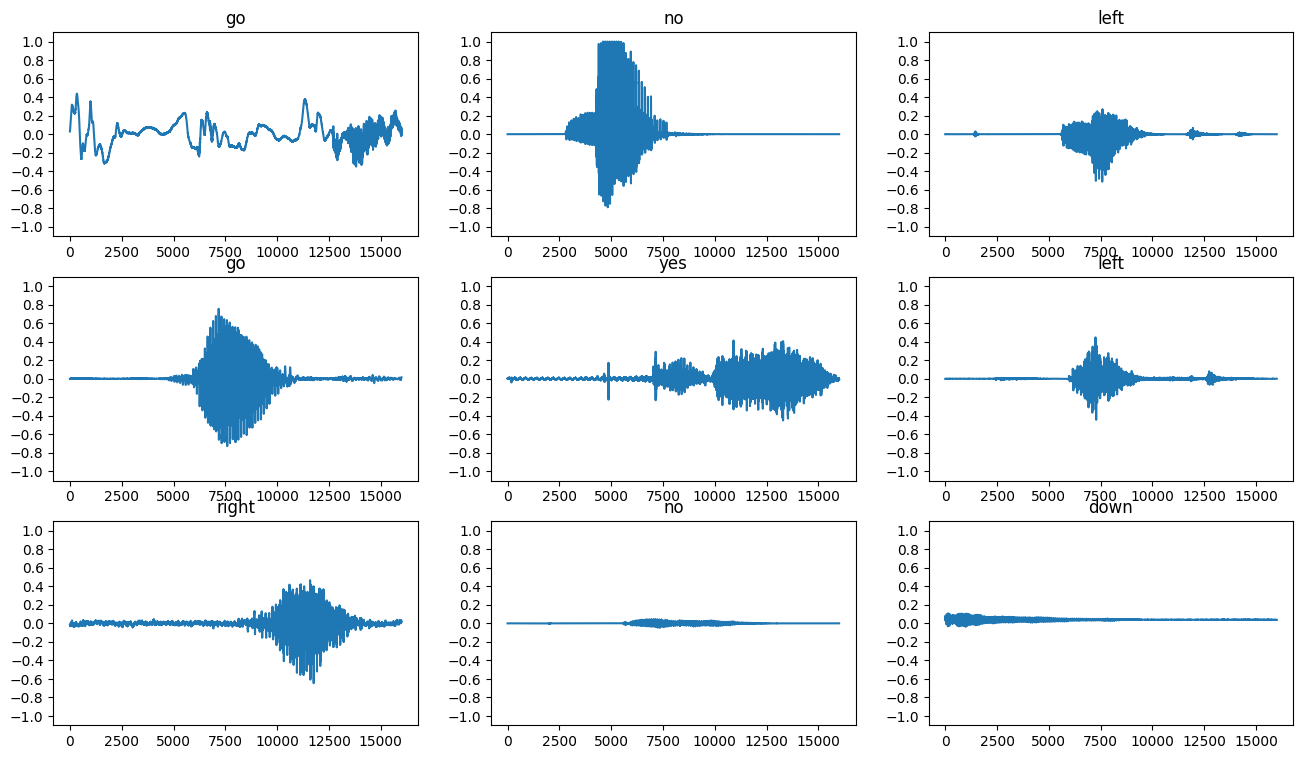

In [182]:

"""
오디오 파형 플롯제작
3rows, 3cols = 9개의 그래프를 제작
"""
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i >= n:
    break
  """ i를 cols로 나눈 몫을 반환합니다. ex) i=12, cols=3 -> i//cols=4 """
  r = i // cols
  """ i를 cols로 나눈 나머지를 반환합니다. ex) i=12, cols=3 -> i%cols=0"""
  c = i % cols
  """
  i | r | c |
  0 | 0 | 0 |
  1 | 0 | 1 |
  2 | 0 | 2 |
  3 | 1 | 0 |
  4 | 1 | 1 |
  5 | 1 | 2 |
  6 | 2 | 0 |
  7 | 2 | 1 |
  8 | 2 | 2 |
  axes[r][c]는 그래프 위치를 위한 변수입니다. axes는 subplots()함수에 의해 반환되는 axes 객체의 배열입니다.
  r은 행 인덱스이고, c는 열 인덱스입니다. matplotlib에서 그래프를 시각화하는 일반적인 방법
  rows=3과 cols=3으로 설정하면 9개의 오디오 샘플을 3 x 3 그리드 형태로 시각화 할 수 있습니다.
  """
  ax = axes[r][c]
  """해당 오디오 샘플의 시계열 데이터를 플롯합니다. audio[i].numpy()는 i번째 오디오 샘플을 가르키는 객체입니다
  .numpy() 메서드는 audio[i]의 데이터를 Numpy 배열로 변환합니다.
  예 : audio[i]가 다음과 같은 값을 가진다고 가정합니다. 
  audio[i] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  이 경우 audio[i].numpy()는 다음과 같은 Numpy 배열을 반환합니다.
  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]"""
  ax.plot(example_audio[i].numpy())
  """y축 눈금을 설정합니다. [-1.0 -0.8 -0.6 -0.4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0]"""
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  """해당 오디오 샘플의 레이블 이름을 가져옵니다."""
  label = label_names[example_labels[i]]
  """해당 오디오 샘플의 레이블 이름을 그래프 제목으로 설정합니다."""
  ax.set_title(label)
  """ 표시되는 y축 범위를 설정합니다. 설정한 눈금만 글자로 나타납니다."""
  ax.set_ylim([-1.1, 1.1])

plt.show()

## 파형을 스펙트로그램으로 변환하기

데이터세트의 파형은 시간 영역에서 표시됩니다. 다음으로, 시간-영역 신호의 파형을 시간-주파수-영역 신호로 변환합니다. 이를 위해 <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">STFT(short-time Fourier transform)</a>를 계산하여 시간에 따른 주파수 변화를 보여주고 2D 이미지로 나타낼 수 있는 <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">스펙트로그램</a>으로 파형을 변환합니다. 스펙트로그램 이미지를 신경망에 공급하여 모델을 훈련시킵니다.

퓨리에 변환(`tf.signal.fft`)은 신호를 성분 주파수로 변환하지만 모든 시간 정보는 손실됩니다. 이에 비해 STFT(`tf.signal.stft`)는 신호를 시간 창으로 분할하고 각 창에서 퓨리에 변환을 실행하여 일부 시간 정보를 보존하고 표준 콘볼루션을 실행할 수 있는 2D 텐서를 반환합니다.

파형을 스펙트로그램으로 변환하기 위한 유틸리티 함수를 생성합니다.

- 파형은 길이가 같아야 스펙트로그램으로 변환할 때 결과가 비슷한 차원을 갖게 됩니다. 이를 위해 1초보다 짧은 오디오 클립을 단순히 0으로 채울 수 있습니다(`tf.zeros` 사용).
- `tf.signal.stft`를 호출할 때 생성된 스펙트로그램 "이미지"가 거의 정사각형이 되도록 `frame_length` 및 `frame_step` 매개변수를 선택합니다. STFT 매개변수 선택에 대한 자세한 내용은 오디오 신호 처리 및 STFT에 대한 <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">이 Coursera 비디오</a>를 참조하세요.
- STFT는 크기와 위상을 나타내는 복소수 배열을 생성합니다. 그러나 이 튜토리얼에서는 `tf.abs`의 출력에 `tf.signal.stft`를 적용하여 유도할 수 있는 크기만 사용합니다.

In [183]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

`spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)`
1. 신호를 frame_length 길이의 시간 창으로 분할합니다.

2. 각 시간 창에서 푸리에 변환을 수행합니다. 푸리에 변환은 시간 영역 신호를 주파수 영역 신호로 변환하는 수학적 기법. 링크설명 : https://twlab.tistory.com/58

3. 푸리에 변환의 크기와 위상을 결합하여 복소수 스펙트로 그램을 생성합니다. 복소수 스펙트로그램은 신호의 진폭과 위상의 정보를 모두 포함하는 2D tensor. 링크설명 : https://www.mathworks.com/help/signal/ref/spectrogram.html

    한줄정리 : 신호를 시간 창으로 분할하고 각 창에서 푸리에 변환을 수행하여 복소수 스펙트로그램을 생성.
    
    복소수 스펙트로그램 모양 : (batch_size, time_steps, frequency_bins, 2)
    - batch_size = 배치크기(전체 데이터 셋을 여러 작은 그룹으로 나누었을 때, 하나의 소그룹에 속하는 데이터 수)를 나타냄
    - time_steps = 시간 축의 크기
    - frequency_bins = 주파수 축의 크기
    - 2 = 복소수 스펙트로그램이 크기와 위상의 두 값을 포함한다는 것을 나타냄.
    아래코드는 tf.signal.stft() 함수를 사용하여 복소수 스펙트로그램을 생성합니다.

    매개변수 : 
    - waveform = 신호를 나타내는 1D tensor
    - frame_length = 시간 창의 길이를 나타내는 정수
    - frame_step = 시간 창 사이의 간격을 나타내는 정수

    매개변수는 복소수 스펙트로그램의 크기와 주파수 해상도를 제어합니다.

`spectrogram = tf.abs(spectrogram)`

복소수 스펙트럼의 크기만 추출합니다.

`spectrogram = spectrogram[..., tf.newaxis]`

스펙트로그램에 채널 차원을 추가합니다. 1. ... 은 스펙트로그램의 모든 차원을 나타냅니다.  2. tf.newaxis 는 새로운 차원을 추가하는 함수입니다.

코드 작동 : 1.스펙트로그램의 모든 차원을 선택합니다.  2. 새로운 차원을 추가합니다.

이 과정을 통한 스펙트로그램 : (batch_size, time_steps, frequency_bins, 1) <- 1개의 채널차워을 가집니다.

채널 차원추가 다른 방법으로는 spectrogram = tf.expand_dims(spectrogram, axis=-1) 이 있습니다.

tf.expand_dims()함수를 사용하여 채널 차원을 추가합니다. 매개변수는 1.input : 차원추가텐서 2.axis : 차원을 추가할 축을 나타내는 정수

`return spectrogram`

처리한 함수결과를 호출자에게 넘겨줍니다.


다음으로, 데이터 탐색을 시작합니다. 한 예의 텐서화된 파형과 해당 스펙트로그램의 형상을 출력하고 원본 오디오를 재생합니다.

In [184]:
for i in range(3):
  """label 변수에 example_labels[i]의 레이블 이름을 할당합니다."""
  label = label_names[example_labels[i]]
  """waveform 변수에  example_audio[i]의 텐서화된 파형을 할당합니다."""
  waveform = example_audio[i]
  """spectrogram 변수에 get_spectrogram() 함수를 사용하여 waveform의 스펙트로그램을 생성합니다."""
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  """waveform 오디오를 재생합니다. 쥬피터 ipynb에서는 오디오가 실행됩니다."""
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


이제 스펙트로그램을 표시하는 함수를 정의합니다.

In [185]:
def plot_spectrogram(spectrogram, ax):
  #1.차원검사 : 스펙트로그램의 차원수를 확인합니다. 2차원 이상이면 스펙트로그램의 마지막 축을 제거합니다.
  if len(spectrogram.shape) > 2:
    #3차원 이상이면 에러 메세지를 표시합니다.
    assert len(spectrogram.shape) == 3
    #축 제거
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  #2.주파수 로그 스케일 및 전치 : spectrogram을 주파수 로그 스케일로 변환합니다.
  #  주파수 성분을 더 잘 볼 수 있도록 합니다. 시간 축을 가로축(열)로, 주파수 축을 세로축(행)으로 전치합니다.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  #3.시각화 : 시각화를 위해 필요한 변수를 계산합니다.
  # height : spectrogram의 높이(행 수, columns)
  height = log_spec.shape[0]
  # width : spectrogram의 너비 (열 수, rows)
  width = log_spec.shape[1]
  # X : 가로축 (시간 표시 값) Numpy의 linspace 함수를 사용하여 spectrogram 너비(간격)의 정수 배열을 만듭니다.
  # line.space(지정된 시작 값, 종료값, 점 개수를 이용한 간격배열)
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  # Y : 세로축 (주파수 표시 값) 범위 함수를 사용하여 0~ 높이-1까지 정수 배열을 만듭니다. 
  Y = range(height)
  #ax.pcolormesh 함수를 사용하여 spectrogram을 색상면으로 시각화 합니다.
  #ax : matplotlib의 Axes 객체, 시각화할 축     log_sepc : 시각화할 스펙트로그램
  ax.pcolormesh(X, Y, log_spec)

`log_spec = np.log(spectrogram.T + np.finfo(float).eps)`은 spcetrogram을 주파수 로그 스케일로 변환합니다. 주파수 성분을 더 잘 볼 수 있도록 합니다. 시간 축을 가로축(열)로, 주파수 축을 세로축(행)으로 전치합니다.

spectrogram은 시간 축과 주파수 축으로 구성된 2차원 tensor입니다. 

시간 축(가로,열,row)은 시간적변화, 주파수 축(세로,행,column)은 신호의 주파수 성분을 나타냄.

로그 스케일 : 값의 범위를 더 잘 볼 수 있도록 하는 방법. 주파수 값을 로그함수를 사용하여 변환.

선형 스케일에서는 값의 변화가 일정한 간격으로 표시됩니다. 예 : 0~100까지 10씩 일정한 간격으로 표시됩니다.

로그 스케일에서는 값을 로그 함수를 사용하여 변환합니다. 로그함수는 값의 변화를 지수적으로 변환합니다.
예 : 0~100까지 값을 로그 스케일로 표시하면, 값의 변화가 10이 아닌 100의 10분의 1씩 일정학 간격으로 표시됩니다.
링크 : https://ko.wikipedia.org/wiki/로그_눈금

`log_spec = np.log(spectrogram.T + np.finfo(float).eps)` 코드는
  1. spectrogram.T 는 spectrogram을 전치합니다. 시간축이 세로축으로, 주파수 축이 가로축으로 이동합니다. 우리가 보는 그래프처럼 배열합니다.
  2. np.log(spectrogram.T + np.finfo(float).eps) 는 spectrogram을 로그 스케일로 변환합니다. 
  
  3. np.finfo(float).eps 는 float 형식의 최소 양수 값입니다. 0으로 나누는 것을 방지하기 위해 사용
  
  즉, log_spec 변수는 시간 축을 세로축으로, 주파수 축을 가로축으로 가진 주파수 로그 스케일 spectrogram을 나타냅니다.
  
  This spectrogram을 시각화하면 주파수 성분을 더 잘 볼 수 있습니다. 예 : 높은 주파수 성분은 밝은 색으로, 낮은 주파수 성분은 어두운색으로 표시됩니다.


시간에 따른 예제의 파형과 해당 스펙트로그램(시간에 따른 주파수)을 플롯합니다.

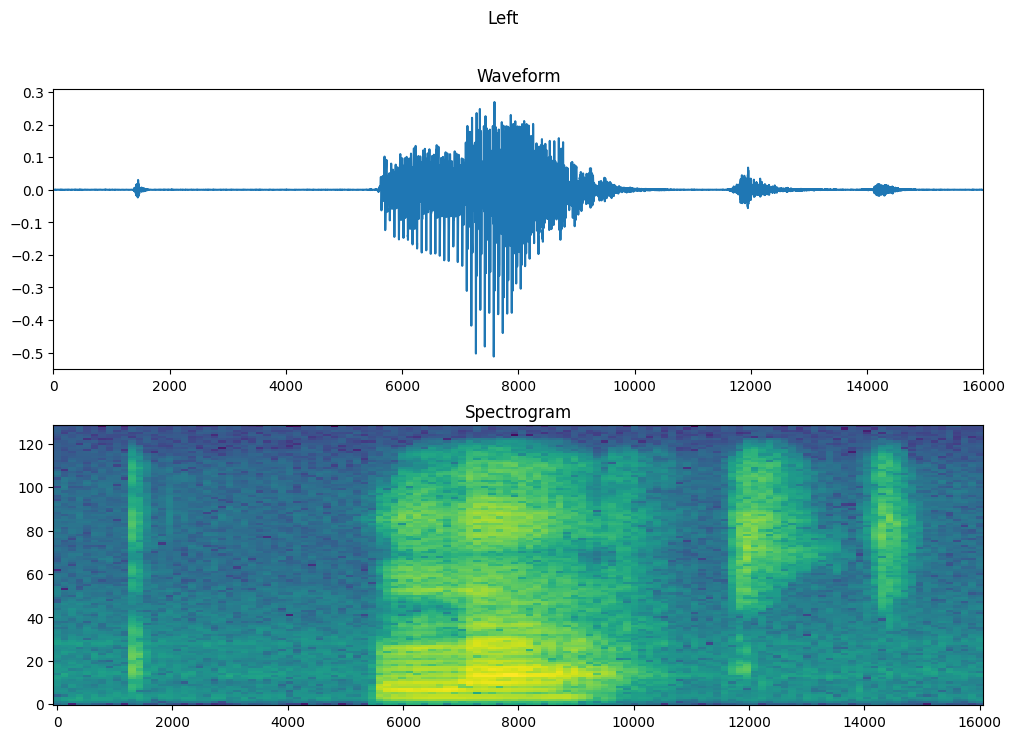

In [186]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

이제 오디오 데이터세트에서 스펙트로그램 데이터세트를 생성합니다.

In [187]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

이 코드는 `make_spec_ds` 함수를 정의하고, 이 함수는 데이터셋 객체 ds를 입력으로 받아 스펙트로그램 데이터셋을 만드는 역할을 합니다.

내부동작 :
- `ds.map(map_func, numparallel_calls):`
- `map_func` : 데이터셋의 각 요소에 적용할 함수입니다. 이 경우 `lambda audio, label: (get_spectrogram(audio), label)`입니다.
- `num_parallel_calls` : 맵 함수를 병렬로 실행할 스레드/코어 수 입니다. `tf.data.AUTOTUNE`은 시스템 리소스를 고려하여 자동으로 최적의 값을 선택합니다.

map_func 상세 설명 :
- `lamda audio, label: (get_spectrogram(audio), label)` : 데이터셋의 각 요소 (audio, label) 쌍을 받아 튜플을 반환합니다.
- audio : 원본 오디오 샘플 데이터입니다.
- label : 오디오 레이블입니다.
- get_spectrogram(audio) : 오디오 샘플에서 스펙트로그램을 생성합니다.
- Tuple : 최종적으로 (스펙트로그램, 레이블) 쌍을 반환합니다.

결과적으로 :
- `make_spec_ds` 함수는 입력 데이터셋 `ds`의 각 요소 (audio, label)쌍[오디오샘플]을 (스펙트로그램, 레이블) 쌍으로 변환하여 새로운 데이터 셋을 만듭니다. 이 새 데이터셋은 스펙트로그램 데이터를 사용하여 머신러닝 모델을 훈련하는 데 사용할 수 있습니다.

In [188]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

데이터세트의 다양한 예에 대한 스펙트로그램을 살펴봅니다.

In [189]:
#데이터셋 train_spectrogram_ds 에서 단 하나의 데이터 포인트만 가져오는 반복문입니다.
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

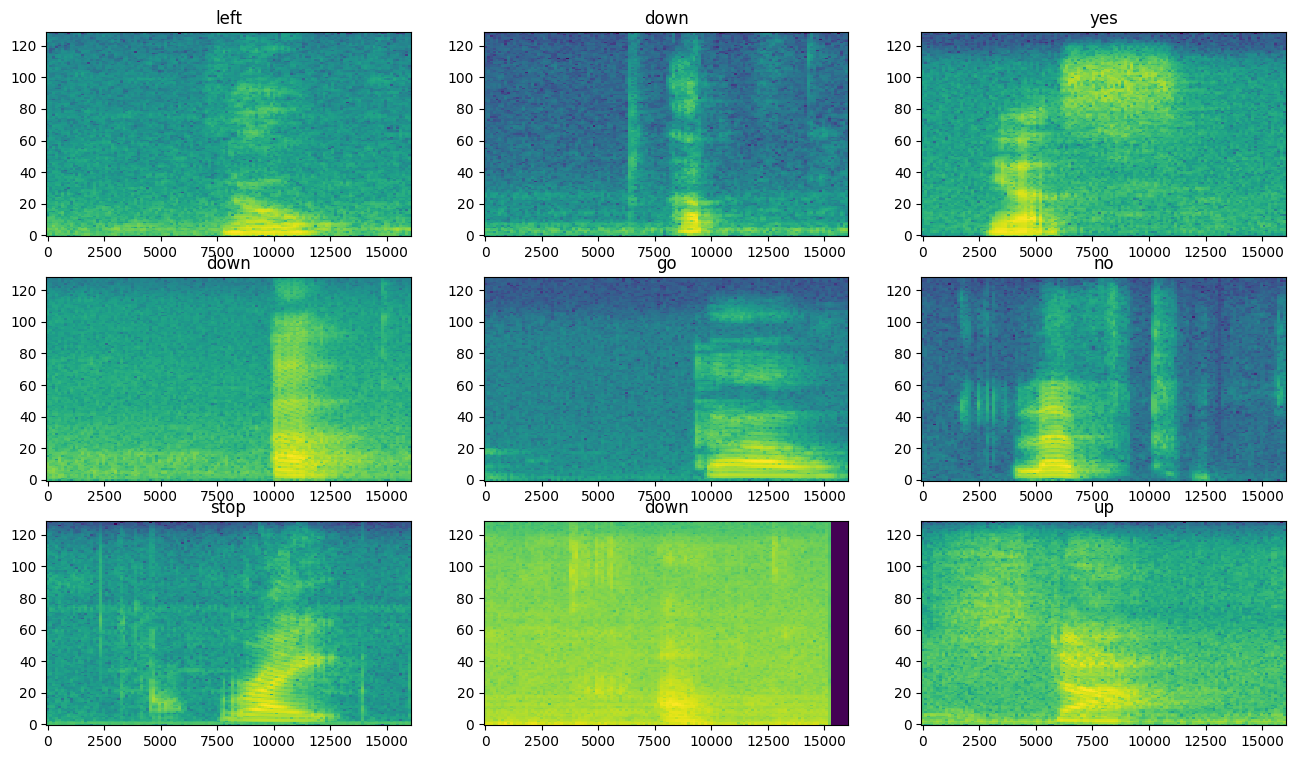

In [190]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## 모델 빌드 및 훈련하기

모델을 훈련하는 동안 읽기 지연 시간을 줄이기 위해 `Dataset.cache` 및 `Dataset.prefetch` 작업을 추가합니다.

In [191]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

1. cache():
캐시 기능은 데이터셋 요소 (스펙트로그램과 레이블)을 메모리에 저장하여 다음 번에 요소에 접근할 때 빠르게 가져올 수 있도록 합니다. 이는 스펙트로그램 계산은 계산 비용이 높기 때문에 유용합니다. 반복적으로 이러한 데이터를 사용할 경우 캐시를 사용하여 계산 시간을 줄일 수 있습니다.

2. shuffle(10000):
Shuffle은 데이터셋 요소를 임의로 섞는 역할을 합니다. 이는 모델 훈련 과정에서 각 배치마다 다른 데이터를 보여주고 과적합(overfitting)을 방지하는 데 도움이 됩니다. 셔플 버퍼 크기는 10000으로 설정되어 있습니다. 즉, 셔플링할 요소를 최대 10000개까지 메모리에 유지합니다.

3. prefetch(tf.data.AUTOTUNE):
Prefetch는 다음 데이터 배치를 미리 준비하는 것입니다. 데이터셋 요소를 CPU로 가져오고 필요한 전처리를 미리 수행합니다. 이렇게 하면 모델 훈련 과정에서 CPU가 데이터 준비 작업에 걸리는 시간을 줄이고 GPU가 효율적으로 활용될 수 있도록 합니다. tf.data.AUTOTUNE은 시스템 리소스를 고려하여 최적의 prefetch 버퍼 크기를 자동으로 선택합니다.

이 모델의 경우, 오디오 파일을 스펙트로그램 이미지로 변환했으므로 간단한 콘볼루션 신경망(CNN)을 사용합니다.

`tf.keras.Sequential` 모델은 다음과 같은 Keras 전처리 레이어를 사용합니다.

- `tf.keras.layers.Resizing`: 모델이 더 빨리 학습할 수 있도록 입력을 다운샘플링합니다.
- `tf.keras.layers.Normalization`: 평균과 표준 편차를 기반으로 이미지의 각 픽셀을 정규화합니다.

`Normalization` 레이어의 경우, 집계 통계(즉, 평균 및 표준 편차)를 계산하기 위해 먼저 훈련 데이터에 대해 해당 `adapt` 메서드를 호출해야 합니다.

In [192]:
#1. 입력모양 및 레이블 : 
#첫 번째 데이터 포인트에서 스펙트로그램의 시간축과 주파수 축 모양을 추출합니다.
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
#사용 가능한 음성 명령 개수를 계산합니다.
num_labels = len(commands)

#2. 정규화 :
# Instantiate the `tf.keras.layers.Normalization` layer.
# Tensorflow Keras의 정규화 레이어를 인스턴스화 합니다.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# 훈련 데이터셋을 사용하여 정규화 레이어의 평균과 분산을 조정합니다.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

#3. 모델구조 :
#순차 모델을 정의합니다.
model = models.Sequential([
    #입력 레이어를 정의하고 스펙트로그램 모양을 지정합니다.
    layers.Input(shape=input_shape),
    # Downsample the input.
    # 스펙트로그램 크기를 32x32로 축소합니다.
    layers.Resizing(32, 32),
    # Normalize.
    #위에서 정의한 정규화 레이어를 추가합니다.
    norm_layer,
    #3 32개의 필터를 사용하는 컨볼루션 레이어를 추가하고 ReLU 활성화 함수를 적용합니다.
    layers.Conv2D(32, 3, activation='relu'),
    # 아래 레이어들 : 추가 컨볼루션 레이어, 맥스풀링,드롭아웃,평탄화,완전 연결 레이어를 사용하여 데이터를 추출하고 분류합니다.
    # 아래 설명 참조
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # 출력 레이어는 사용 가능한 명령 개수만큼 뉴런을 가지며 소프트맥스 활성화 함수를 사용하여 각 클래스의 확률을 예측
    layers.Dense(num_labels),
])
#4. 모델 요약 : 모델의 구성 및 매개변수 개수를 출력합니다.
model.summary()

Input shape: (124, 129, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)      

1. layers.Conv2D(64, 3, activation='relu'):
- 이 레이어는 64개의 필터를 사용하는 2차원 컨볼루션 레이어입니다. 필터는 3x3 크기의 창이며 이미지 (현재는 스펙트로그램) 위를 이동하면서 특징을 추출합니다.
- 64개의 필터는 각각 스펙트로그램의 다른 부분에서 유용한 특징을 찾기 위해 학습됩니다. 예를 들어, 일부 필터는 수평선 특징을, 다른 필터는 특정 주파수 대역의 에너지를 탐지할 수 있습니다.
- 'relu' 활성화 함수는 필터가 음이 아닌 값을 출력하도록 합니다.
2. layers.MaxPooling2D():
- 이 레이어는 최대 풀링(max pooling)을 수행합니다. 풀링 창은 일반적으로 2x2 크기이며 각 창에서 가장 큰 값만 가져옵니다. 이는 특징 크기를 줄이면서 가장 중요한 정보를 유지하는 역할을 합니다.
3. layers.Dropout(0.25):
- 이 레이어는 25%의 뉴런을 랜덤하게 비활성화하는 드롭아웃을 수행합니다. 드롭아웃은 과적합(overfitting)을 방지하기 위해 도움이 됩니다. 비활성화된 뉴런은 훈련 과정에서 업데이트되지 않지만 추론 과정에서 다시 활성화되어 성능 향상에 도움이 됩니다.
4. layers.Flatten():
- 이 레이어는 2차원 텐서를 1차원 벡터로 평탄화합니다. 이는 완전 연결 레이어를 사용할 수 있도록 스펙트로그램 데이터를 준비하는 역할을 합니다.
5. layers.Dense(128, activation='relu'):
- 이 레이어는 128개의 뉴런을 가진 완전 연결 레이어입니다. 평탄화된 스펙트로그램 데이터를 입력으로 받고 다중 퍼셉트론을 통해 더 복잡한 특징을 추출합니다.
- 'relu' 활성화 함수는 음이 아닌 값만 출력하도록 합니다.
6. layers.Dropout(0.5):
- 이 레이어는 50%의 뉴런을 랜덤하게 비활성화하는 드롭아웃을 수행합니다. 앞선 드롭아웃과 같은 역할을 합니다.
7. layers.Dense(num_labels):
- 이 레이어는 최종 출력 레이어입니다. 'num_labels'만큼 뉴런을 가지며 각 뉴런은 특정 음성 명령에 대한 예측 확률을 출력합니다. 소프트맥스 활성화 함수는 모든 뉴런의 합이 1이 되도록 출력을 확률 분포로 변환합니다.

즉, 컨볼루션 레이어, 풀링, 드롭아웃, 평탄화, 완전연결 레이어를 사용하여 스펙트로그램 데이터에서 즉징을 추출하고 더 복잡한 정보를 확습합니다. 이 정보는 최종 레이어에서 사용가능한 음성 명령에 대한 예측 확률을 계산하는 데 사용됩니다.

Adam 옵티마이저와 교차 엔트로피 손실을 사용하여 Keras 모델을 구성합니다.

In [193]:
# 훈련과정에서 모델을 조정하기 위한 설정을 지정하는 model.compile() 함수를 호출합니다.
model.compile(
    # 모델 파라미터를 업데이트하는 알고리즘으로 Adam 최적화 함수를 사용합니다. Adam은 일반적으로 빠르고 안정적으로 수렴, 널리 사용되는 최적화 함수
    optimizer=tf.keras.optimizers.Adam(),
    # 모델 성능을 측정하는 손실함수 설정. 희소 카테고리 교차 엔트로피 손실 함수를 사용.
    # 최종 출력 레이어가 로그값을 출력한다는 것을 나타내는 from_logits=True 옵션을 사용.
    # 이 손실함수는 모델이 예측한 클랙스 확률과 실제 클래스 레이블 간의 차이를 측정함
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # 훈련 및 테스트 과정에서 모니터링할 지표를 설정. 여기서는 분류 정확도만을 추적함.
    metrics=['accuracy'],
)

위 코드는 Adam 최적화 함수를 사용하여 모델 파라미터를 업데이트하고, 희소 카테고리 교차 엔트로피 손실 함수를 사용하여 모델 성능을 측정하며, 분류 정확도를 추적하여 모델 성능을 모티너링함.

희소 카테고리 교차 엔트로피 손실함수란?

`L(y, p) = -sum(y * log(p))`
- y는 실제 클래스 레이블 벡터
- p는 모델이 예측한 클래스 확률 벡터

예 :

실제 클래스 레이블이 [1,0,0], 모델 예측 클래스 확률이 [0.8,0.1,0.1] 인 경우, 손실함수는 다음과 같음.

`L = -(1 * log(0.8) + 0 * log(0.1) + 0 * log(0.1))`
= -log (0.8) = 0.2231

특징 :
- 멀티클래스 분류 문제에 적합
- 모델이 예측한 클래스 확률을 직접 사용
- 소프트맥스 활성화 함수를 사용하는 모델과 함께 사용하면 간단하게 구현가능

데모 목적으로 10번의 epoch에 걸쳐 모델을 훈련합니다.

In [194]:
#훈련 반복회수를 10회로 설정합니다.
EPOCHS = 10
#history : 훈련과정 중 기록된 손실 값, 정확도 등의 지표를 저장하는 개체. 훈련결과를 차후 분석가능
#model.fit함수를 사용하여 모델을 훈련합니다.
history = model.fit(
    #훈련 데이터셋을 입력합니다.
    train_spectrogram_ds,
    #검증 데이터셋을 입력합니다. 훈련과정 중 모델 성능을 모니터링 하는 데 사용됩니다.
    validation_data=val_spectrogram_ds,
    #훈련 반복 횟수를 지정합니다.
    epochs=EPOCHS,
    # 훈련 과정 중 성능 개선이 2회 연속 이루어지지 않으면 훈련을 중단하는 early stopping call back 함수를 설정합니다.
    # verbos=1 은 훈련 중 early stopping 사애에 대한 메세지를 출력합니다.
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2023-12-13 13:32:26.294616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


100/100 [==============================] - 3s 22ms/step - loss: 1.9058 - accuracy: 0.3147 - val_loss: 1.4687 - val_accuracy: 0.5312
Epoch 2/10
100/100 [==============================] - 2s 20ms/step - loss: 1.4049 - accuracy: 0.5431 - val_loss: 1.1175 - val_accuracy: 0.6523
Epoch 3/10
100/100 [==============================] - 2s 20ms/step - loss: 1.1106 - accuracy: 0.6628 - val_loss: 1.1518 - val_accuracy: 0.6927
Epoch 4/10
100/100 [==============================] - 2s 20ms/step - loss: 1.0113 - accuracy: 0.7189 - val_loss: 2.0477 - val_accuracy: 0.6589
Epoch 4: early stopping


위 코드는 10회 반복으로 모델을 훈련하고, 성능 개선이 2회 연속 이루어지지 않으면 훈련을 중단하며, 훈련경과를 저장하는 역할을 합니다.

훈련 및 유효성 검증 손실 곡선을 플롯하여 훈련 중에 모델이 어떻게 개선되었는지 확인하겠습니다.

Text(0, 0.5, 'Accuracy [%]')

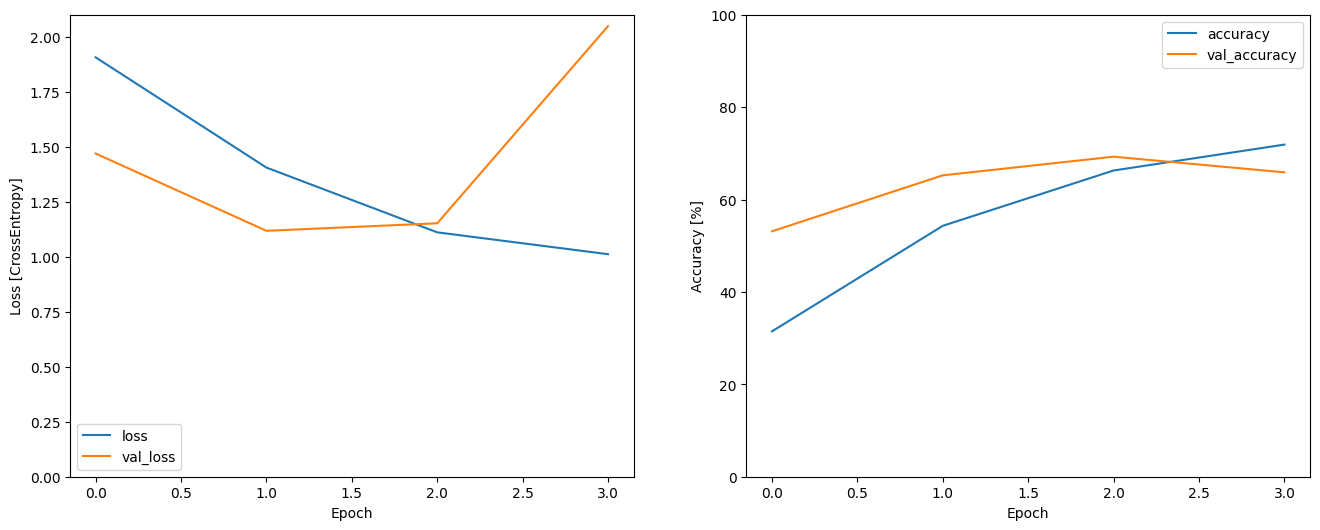

In [195]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## 모델 성능 평가하기

테스트세트에서 모델을 실행하고 모델의 성능을 확인합니다.

In [196]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 15ms/step - loss: 2.0588 - accuracy: 0.6755


{'loss': 2.0588436126708984, 'accuracy': 0.6754807829856873}

### 혼동 행렬 표시하기

<a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">혼동 행렬</a>을 사용하여 모델이 테스트세트의 각 명령을 얼마나 잘 분류했는지 확인합니다.


In [197]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 8ms/step


In [198]:
y_pred = tf.argmax(y_pred, axis=1)

In [199]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

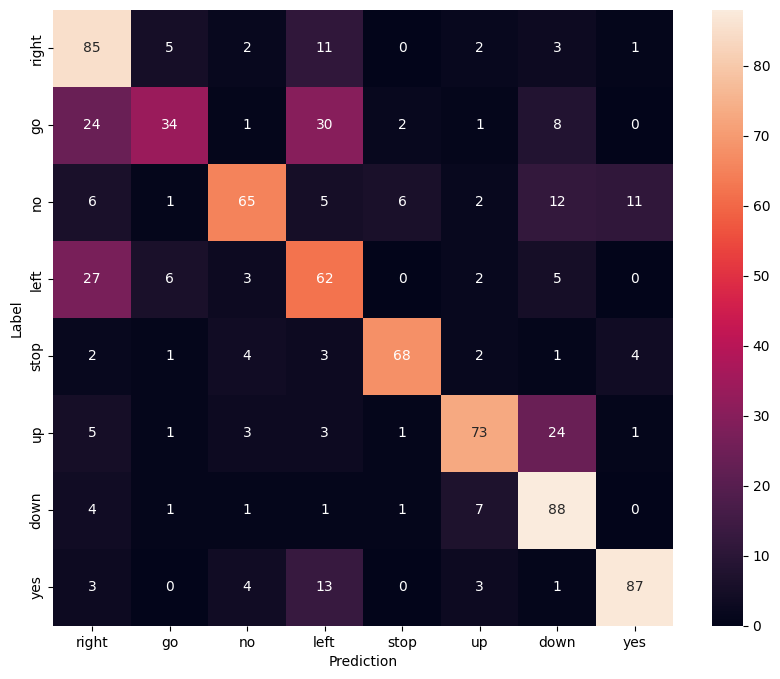

In [200]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 오디오 파일에 대한 추론 실행하기

마지막으로, "no"라고 말하는 사람의 입력 오디오 파일을 사용하여 모델의 예측 출력을 확인합니다. 모델의 성능은 어느 정도인가요?

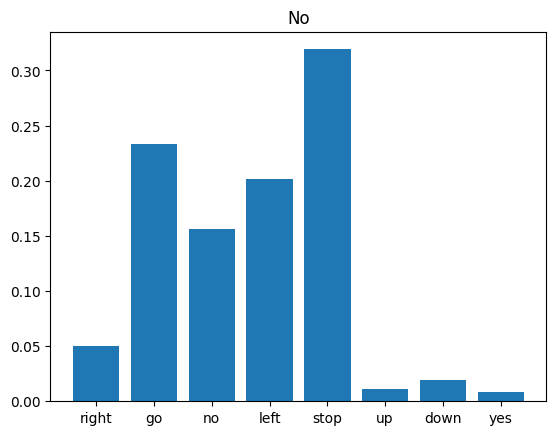

In [201]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

출력에서 알 수 있듯이 모델은 오디오 명령을 "no"로 인식해야 합니다.

## 전처리로 모델 내보내기

추론을 위해 데이터를 모델에 전달하기 전에 이러한 전처리 단계를 적용해야 하는 경우 모델을 사용하기가 쉽지 않습니다. 따라서 전체 버전을 빌드하세요.

모델을 저장해서, 어디서나 훈련이 필요없이 불러와서 사용가능한 상태로 만듭니다.

In [202]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

**1. 멤버 변수:**

* `model`: 훈련된 음성 명령 분류 모델을 저장합니다.

```python
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model
```

`ExportModel` 클래스의 생성자는 `model` 인수를 받아 `self.model` 멤버 변수에 저장합니다. `model`은 훈련된 음성 명령 분류 모델입니다.

**2. 생성자:**

* `model` 인수를 받아 멤버 변수에 저장합니다.
* 두 가지 **concrete functions** 를 정의합니다.
    * 하나는 문자열 파일 이름을 입력으로 받는 함수 (`shape=(), dtype=tf.string`).
    * 다른 하나는 웨이브폼 배열을 입력으로 받는 함수 (`shape=[None, 16000], dtype=tf.float32`).
    이 함수들은 서로 다른 데이터 형식에 대해 모델을 호출할 수 있도록 합니다.

```python
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))
```

`__call__()` 메서드는 모델을 호출합니다. 입력 `x`가 문자열 파일 이름인 경우, `tf.io.read_file()` 함수를 사용하여 파일을 읽고, `tf.audio.decode_wav()` 함수를 사용하여 16kHz 샘플 속도로 디코딩하고, `tf.squeeze()` 함수를 사용하여 단일 채널로 변환하고, `tf.newaxis`를 사용하여 배열을 모델에 입력하기 위한 형식으로 변경합니다. 입력 `x`가 웨이브폼 배열인 경우, 전처리를 수행하지 않습니다.

```python
  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}
```

`__call__()` 메서드는 다음과 같이 출력을 반환합니다.

* `predictions`: 모델의 예측 확률
* `class_ids`: 모델의 예측 클래스 ID
* `class_names`: 모델의 예측 클래스 이름

**3. __call__ 메서드:**

* 모델을 호출합니다.
* 입력 `x`가 문자열 파일 이름인 경우:
    * 파일을 읽고 디코딩합니다.
    * 단일 채널로 변환하고 16000개 샘플로 구성된 배열로 만듭니다.
    * 배열을 모델에 입력하기 위한 형식으로 변경합니다.
* 입력 `x`가 웨이브폼 배열인 경우:
    * 전처리를 수행하지 않습니다.
* 스펙트로그램을 계산합니다.
* 훈련 모드를 False로 설정하여 모델을 추론합니다.
* 예측 결과, 클래스 ID, 클래스 이름을 각각 `predictions`, `class_ids`, `class_names` 키로 딕셔너리에 담아 반환합니다

"내보내기" 모델을 테스트 실행합니다.

In [203]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 2.5927496,  3.810251 , -1.7202163,  4.177448 , -0.8675211,
         -1.1459004, -1.5874695, -3.0555956]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

모델을 저장하고 다시 로드하면 다시 로드된 모델이 동일한 출력을 제공합니다.

In [204]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 2.5927496,  3.810251 , -1.7202163,  4.177448 , -0.8675211,
         -1.1459004, -1.5874695, -3.0555956]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

## 다음 단계

이 튜토리얼에서는 TensorFlow 및 Python과 함께 콘볼루션 신경망을 사용하여 간단한 오디오 분류/자동 음성 인식을 수행하는 방법을 보여주었습니다. 자세히 알아보려면 다음 리소스를 살펴보세요.

- [YAMNet을 사용한 사운드 분류](https://www.tensorflow.org/hub/tutorials/yamnet) 튜토리얼 - 오디오 분류를 위해 전이 학습을 사용하는 방법을 보여줍니다.
- <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle의 TensorFlow 음성 인식 챌린지</a>에 기초한 노트북
- <a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - 전이 학습 코드랩을 사용한 오디오 인식</a> - 오디오 분류를 위한 대화형 웹 앱을 직접 구축하는 방법을 알려줍니다.
- <a href="https://arxiv.org/abs/1709.04396" class="external">음악 정보 검색을 위한 딥 러닝 튜토리얼</a>(Choi 등, 2017) - arXiv에서 제공
- TensorFlow에서 [오디오 데이터 준비 및 확장](https://www.tensorflow.org/io/tutorials/audio)을 위한 추가 지원 제공 - 자체 오디오 기반 프로젝트를 쉽게 진행할 수 있습니다.
- 음악 및 오디오 분석을 위한 Python 패키지인 <a href="https://librosa.org/" class="external">librosa</a> 라이브러리 사용을 고려하세요.